# Estimating-the-correlation-length 

* A central parameter for the `DIVAnd` analysis is the correlation length.
* It determines whether two points separated by a given distance are correlated or not.
* `DIVAnd` includes several tools to estimate the correlation length.
* We will start with a 2D case and consider the 3D case.

In [16]:
using DIVAnd
using PyPlot
if VERSION >= v"0.7.0-beta.0"
    using Dates
    using Statistics
    using Random
else
    using Compat: @info, @warn, @debug
end
using Compat

# Data reading
Download the file `Salinity.bigfile` (if it is not already present). It will be placed in the same directory as this notebook. This file is a space-separated file containing data based on the [World Ocean Database](https://www.nodc.noaa.gov/OC5/WOD/pr_wod.html).

In [3]:
fname = "./data/Salinity.bigfile"

if !isfile(fname)
    download("https://b2drop.eudat.eu/s/Bv9Fj0YGC0zp2vn/download",fname)
else
    @info("Data file already downloaded")
end

┌ Info: Data file already downloaded
└ @ Main In[3]:6


Load the data

In [4]:
obsval,obslon,obslat,obsdepth,obstime,obsid = loadbigfile(fname);

┌ Info: Loading data from 'big file' ./data/Salinity.bigfile
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/OWNKi/src/load_obs.jl:10


`mincount` is the minimum number of observations per distance bin and the call to [`seed!`](https://docs.julialang.org/en/v1/stdlib/Random/#Random.seed!) (seed for the random number generator) ensures a reproducible sequence of random numbers.

In [5]:
mincount = 100
Random.seed!(12345);

UndefVarError: UndefVarError: Random not defined

## 2D case

* First lets consider only the data on a 2D surface (longitude and latitude)
* We use the function `DIVAnd.fit_isotropic`


In [6]:
?fit_isotropic

search: fit_isotropic



```
var0,len,distx,covar,fitcovar = fit_isotropic(x,v,distbin,mincount;
                           alpha = DIVAnd.alpha_default(length(x)),
                           minlen = 0.,
                           maxlen = 10.,
                           tolrel = 1e-4,
                           maxpoints = 10000,
                           nmean = 100,
                           distfun = (xi,xj) -> sqrt(sum(abs2,xi-xj))),
                           progress = (iter,var,len,fitness) -> nothing
                       )
```

Determines the optimal correlation length `len` and variance (for a separation distance approaching zero) `var0` of a cloud of data points with value `v` and coordiantes `x` (tuple of vectors with the coordinates).

The function can find the solution corresponding to a local minimum which is not necessarily the global minimum.

See also `empiriccovar` for future information about the output parameters.

Optional input parameters:

  * `alpha`: if one correlation length is forced to zero during the anaylsis the values of alpha sould be set using the effective dimension. For example, if a 2D-analysis is simulated by forcing the vertical correlation length to zero, then alpha should be set to `[1,2,1]`, otherwise alpha will be `[1,3,3,1]` (for any proper 3D analysis).
  * `len`: initial value for the correlation length.
  * `minlen`, `maxlen`: minimum and maximum values for the correlation length.
  * `tolrel`: relative tolerance for the optimizer.
  * `maxpoints`: maximum number of data points considered.
  * `nmean`: the number of times an empirical covariance is estimated.  The average covariance is used for the fitting.
  * `distfun`: function to compute the distance between point `xi` (vector) and  `xj`. Per default `distfun` is the Euclidian distance: `(xi,xj) -> sqrt(sum(abs2,xi-xj)))`.
  * `progress`: call-back function to show the progress of the optimization with the input parameters `iter`, `var`, `len` and `fitness` (all scalars).

The length-scale parameters and the variance have the corresponding units from the `x` and `v`. It is therefore often necessary to provide reasonable values for these default parameters.

The algorithm used to estimate the correlation-length and variance is based on randomly choosen points. Therefore the result can be different if the function is invoked repeately. If `nmean` is increased, then these statistical fluctuations should decrease (for a not too large value of `mincount`, i.e. about 100 for most cases).

If the lower bound `minlen` is too small, then you might get the following error:

```
AmosException with id 4: input argument magnitude too large, complete loss of accuracy by argument reduction.
```

In these case, increase `minlen`.


## Example 1: salinity in the Black Sea
The profiles were already vertically interpolated on standard depth levels.     
We select the values near surface and for the month of January.

In [7]:
# surface values for the month January
sel = (obsdepth .< 10) .& Dates.month.(obstime) .== 1;
x = (obslon[sel],obslat[sel]);
v = obsval[sel] .- mean(obsval[sel]);
distbin = 0:0.5:4

var0,len,distx,covar,fitcovar = fit_isotropic(x,v,distbin,mincount)

(27.643038291777724, 0.38904851485148517, [0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75], [27.643, 10.5135, 3.71597, 1.03839, 0.158558, -0.693598, -0.944672, -1.16542], [21.0597, 8.19949, 2.76758, 0.881941, 0.272328, 0.0824272, 0.0246064, 0.00727157], [7.11211, 3.31297, 1.79098, 0.703518, 0.259621, 0.40089, 0.367788, 0.336057])

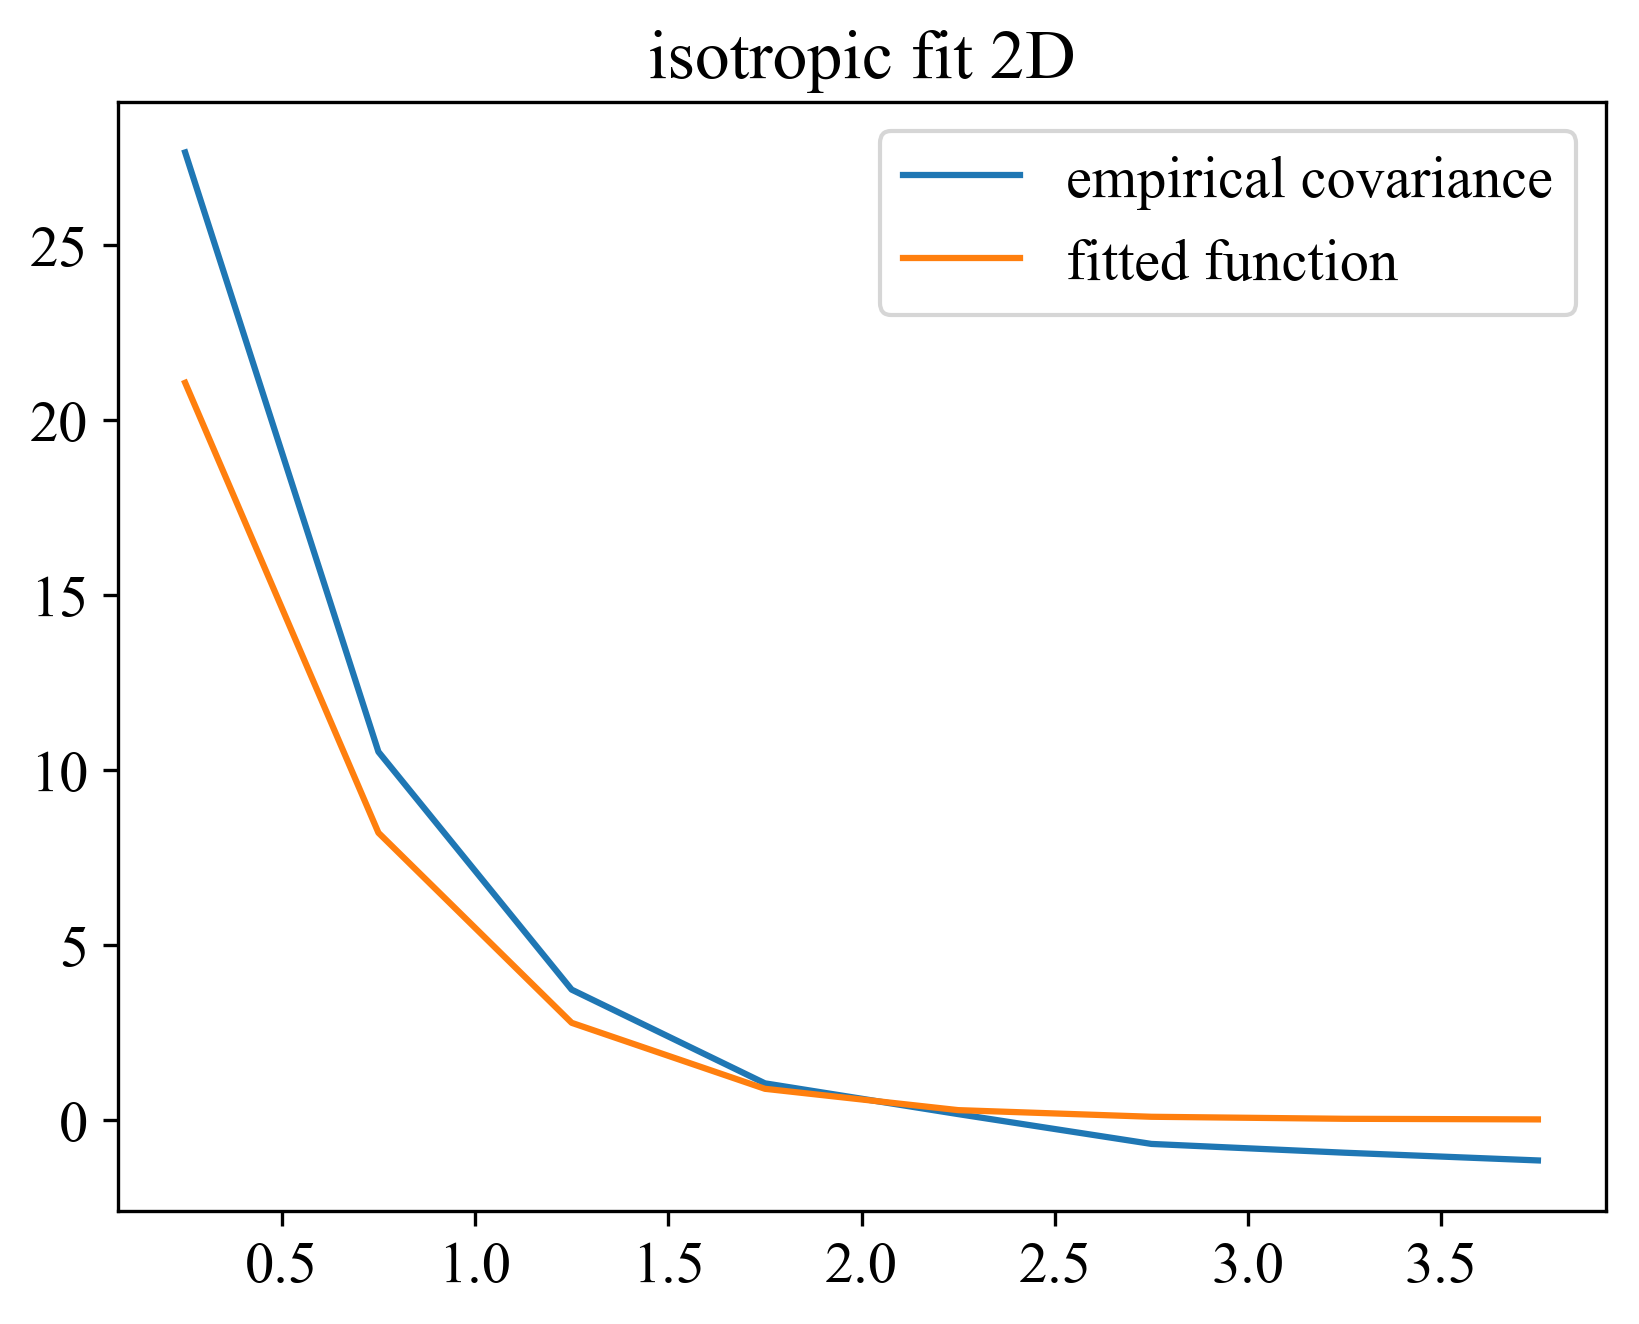

PyObject Text(0.5,1,'isotropic fit 2D')

In [8]:
figure()
plot(distx,covar, label = "empirical covariance")
plot(distx,fitcovar, label = "fitted function")
legend()
title("isotropic fit 2D")

The data from the file `Salinity.bigfile` is already interpolated on standard depth levels, which makes it not ideal to explore the vertical correlation.
The file `WOD-Salinity-Provencal.nc` contains salinity measurement obtained from the World Ocean Database for the Provençal Basin (Mediterranean Sea).

The resulting correlation length can fluctuate a bit because the correlation is based on a collection of random pairs. Increasing the parameter `nmean` can make the estimation of the correlation more robust.

* Load the data file if it is not already present.
* Note we do not use the file `Salinity.bigfile` because it correspond to data already vertically interpolated which is not optimal for estimating the vertical correlation length

## Example 2: salinity in the Provençal Basin
In this case, the profiles were not interpolated vertically.

In [9]:
varname = "Salinity"
filename = "data/WOD-Salinity-Provencal.nc"

if !isfile(filename)    
    download("https://b2drop.eudat.eu/s/UsF3RyU3xB1UM2o/download",filename)
else
    @info("Data file $filename already downloaded")
end

┌ Info: Data file data/WOD-Salinity-Provencal.nc already downloaded
└ @ Main In[9]:7


Load the data and print basic information about it that can be used for quality check.

In [10]:
obsval,obslon,obslat,obsdepth,obstime,obsid = loadobs(Float64,filename,"Salinity")
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

┌ Info: Checking ranges for dimensions and observations
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/OWNKi/src/obsstat.jl:75


              minimum and maximum of obs. dimension 1: (3.0418334007263184, 11.8100004196167)
              minimum and maximum of obs. dimension 2: (42.0, 44.0)
              minimum and maximum of obs. dimension 3: (-0.0, 2762.0)
              minimum and maximum of obs. dimension 4: (1892-09-25T00:00:00, 2017-10-02T06:14:02.761)
                          minimum and maximum of data: (0.25, 40.0)


For this example we select only the first month (January)

In [11]:
sel = (Dates.month.(obstime) .== 1)
x = (obslon[sel],obslat[sel],obsdepth[sel]);
v = obsval[sel]
z = [0.,10,100,200,300,400,500,700,1000,1500];

### Horizontal correlation length
Estimate the horizontal correlation length for different depth levels    
(can take a few minutes).

In [17]:
Random.seed!(1234);
@time lenxy,infoxy = fithorzlen(x,v,z)

┌ Warning: Be patient big data set: 18551
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/OWNKi/src/fit.jl:673
┌ Info: Data points at z=0.0: 18551, horz. correlation length: 0.29007691140344244
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/OWNKi/src/fit.jl:1044
┌ Warning: Be patient big data set: 21948
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/OWNKi/src/fit.jl:673
┌ Info: Data points at z=10.0: 21948, horz. correlation length: 0.24386004187260396
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/OWNKi/src/fit.jl:1044
┌ Warning: Be patient big data set: 30934
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/OWNKi/src/fit.jl:673
┌ Info: Data points at z=100.0: 30934, horz. correlation length: 0.14412036850353693
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/OWNKi/src/fit.jl:1044
┌ Warning: Be patient big data set: 26778
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/OWNKi/src/fit.jl:673
┌ Info: Data points at z=200.0: 26778, horz. correlation length: 0.10668776687076267
└ 

 29.564480 seconds (263.88 M allocations: 23.017 GiB, 9.25% gc time)


([0.197056, 0.196545, 0.169715, 0.178555, 0.357048, 0.96819, 2.24855, 0.341083, 0.102336, 0.178143], Dict{Symbol,Array{T,1} where T}(:fitinfos=>Dict{Symbol,Any}[Dict(:sn=>0.247778,:rqual=>0.829354,:fitcovar=>[NaN, 0.0144328, 0.0140492, 0.0135558, 0.0129967, 0.0123997, 0.0117836, 0.0111618, 0.010544, 0.00993722  …  3.27876e-14, 2.99747e-14, 2.7403e-14, 2.50519e-14, 2.29023e-14, 2.09371e-14, 1.91404e-14, 1.74979e-14, 1.59962e-14, 1.46233e-14],:meandist=>2.11735,:covar=>[0.0193498, 0.0162112, 0.0129696, 0.0113905, 0.0108127, 0.0104314, 0.0104475, 0.0110948, 0.0117915, 0.0120529  …  0.0380852, 0.0339701, 0.030239, 0.0356776, 0.0531402, 0.0698109, 0.0711506, 0.0698813, 0.0966162, 0.136982],:range=>2:20,:distx=>0.0:0.026466871478416282:8.575266359006875,:covarweight=>[7.41491e10, 1.0906e11, 7.63083e10, 7.82751e10, 7.47015e10, 7.83169e10, 7.6959e10, 7.66246e10, 7.38995e10, 7.7564e10  …  8.84924e10, 7.37388e10, 4.19717e11, 0.0, 7.37185e10, 1.33979e11, 7.37185e10, 0.0, 0.0, 7.37186e10]), Dict(:

Make a plot of the horizontal correlation length with respect to the depth.

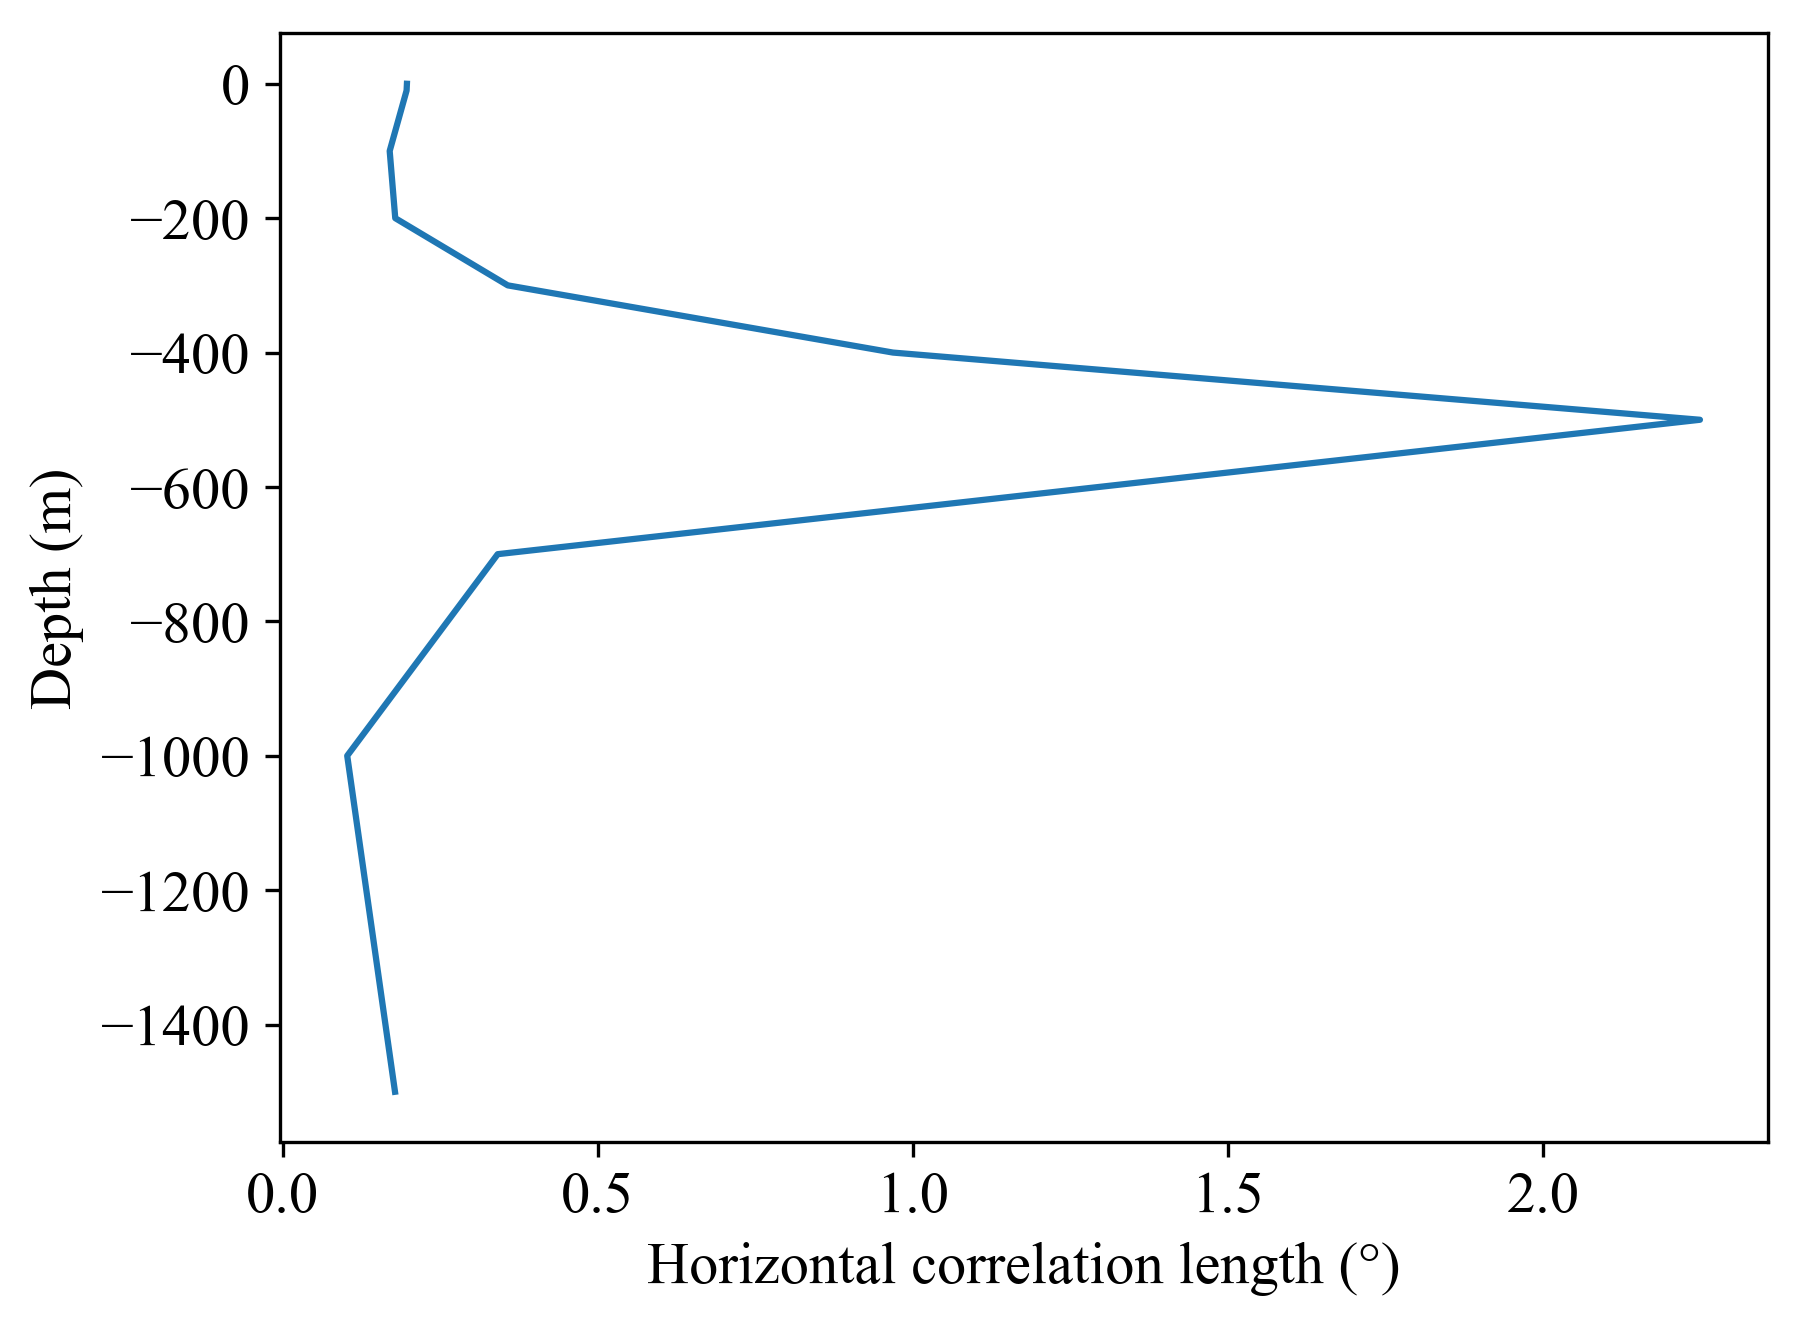

In [18]:
plot(lenxy,-z)
xlabel("Horizontal correlation length (°)")
ylabel("Depth (m)");

### Vertical correlation length 
The vertical correlation length is also estimated for different depth levels

In [19]:
Random.seed!(1234);
@time lenz,infoz = fitvertlen(x,v,z)

┌ Info: Vert. correlation length at z=0.0: 53.67600000000001
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/OWNKi/src/fit.jl:1112
┌ Warning: Too few data. Will use guesses (np = 9, RLz = 204.32, )
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/OWNKi/src/fit.jl:890
┌ Info: Vert. correlation length at z=10.0: 204.32
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/OWNKi/src/fit.jl:1112
┌ Warning: Too few data. Will use guesses (np = 9, RLz = 174.46508544921875, )
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/OWNKi/src/fit.jl:890
┌ Info: Vert. correlation length at z=100.0: 174.46508544921875
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/OWNKi/src/fit.jl:1112
┌ Info: Vert. correlation length at z=200.0: 599.560704
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/OWNKi/src/fit.jl:1112
┌ Warning: Too few data. Will use guesses (np = 9, RLz = 181.6, )
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/OWNKi/src/fit.jl:890
┌ Info: Vert. correlation length at z=300.0: 181.6
└ @ DIVAnd 

  5.258052 seconds (98.72 M allocations: 3.952 GiB, 11.60% gc time)


┌ Info: Vert. correlation length at z=1500.0: 2999.0190152841765
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/OWNKi/src/fit.jl:1112


([217.093, 218.036, 268.62, 374.911, 272.553, 246.911, 366.908, 467.274, 1903.42, 2977.67], Dict{Symbol,Array{T,1} where T}(:fitinfos=>Dict{Symbol,Any}[Dict(:sn=>10000.0,:rqual=>0.789256,:fitcovar=>[NaN, 0.0301741, 0.0243761, 0.0189271, 0.0143602, 0.0107294, 0.00792922, 0.00581166, 0.00423225, 0.00306615  …  8.9242e-20, 6.18824e-20, 4.29091e-20, 2.9752e-20, 2.06286e-20, 1.43023e-20, 9.91582e-21, 6.87444e-21, 4.76575e-21, 3.30378e-21],:meandist=>389.212,:covar=>[0.247322, 0.210605, 0.165193, 0.131589, 0.109884, 0.0901948, 0.065987, 0.0411952, 0.0230737, 0.0140224  …  7.06944e-7, 0.0, 0.0, 0.0, -2.00278e-5, -0.000120167, -0.000256634, -9.40767e-5, 0.00061902, 0.0013922],:range=>2:15,:distx=>0.0:19.880000000000003:2465.1200000000003,:covarweight=>[1.169e12, 1.169e12, 1.169e12, 1.169e12, 1.169e12, 1.169e12, 1.169e12, 1.169e12, 1.169e12, 1.169e12  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.85359e12, 0.0, 1.62947e12]), Dict(:sn=>0.010101,:rqual=>0.0,:fitcovar=>[NaN, 0.000335271, 0.000324999, 0.

Make a plot

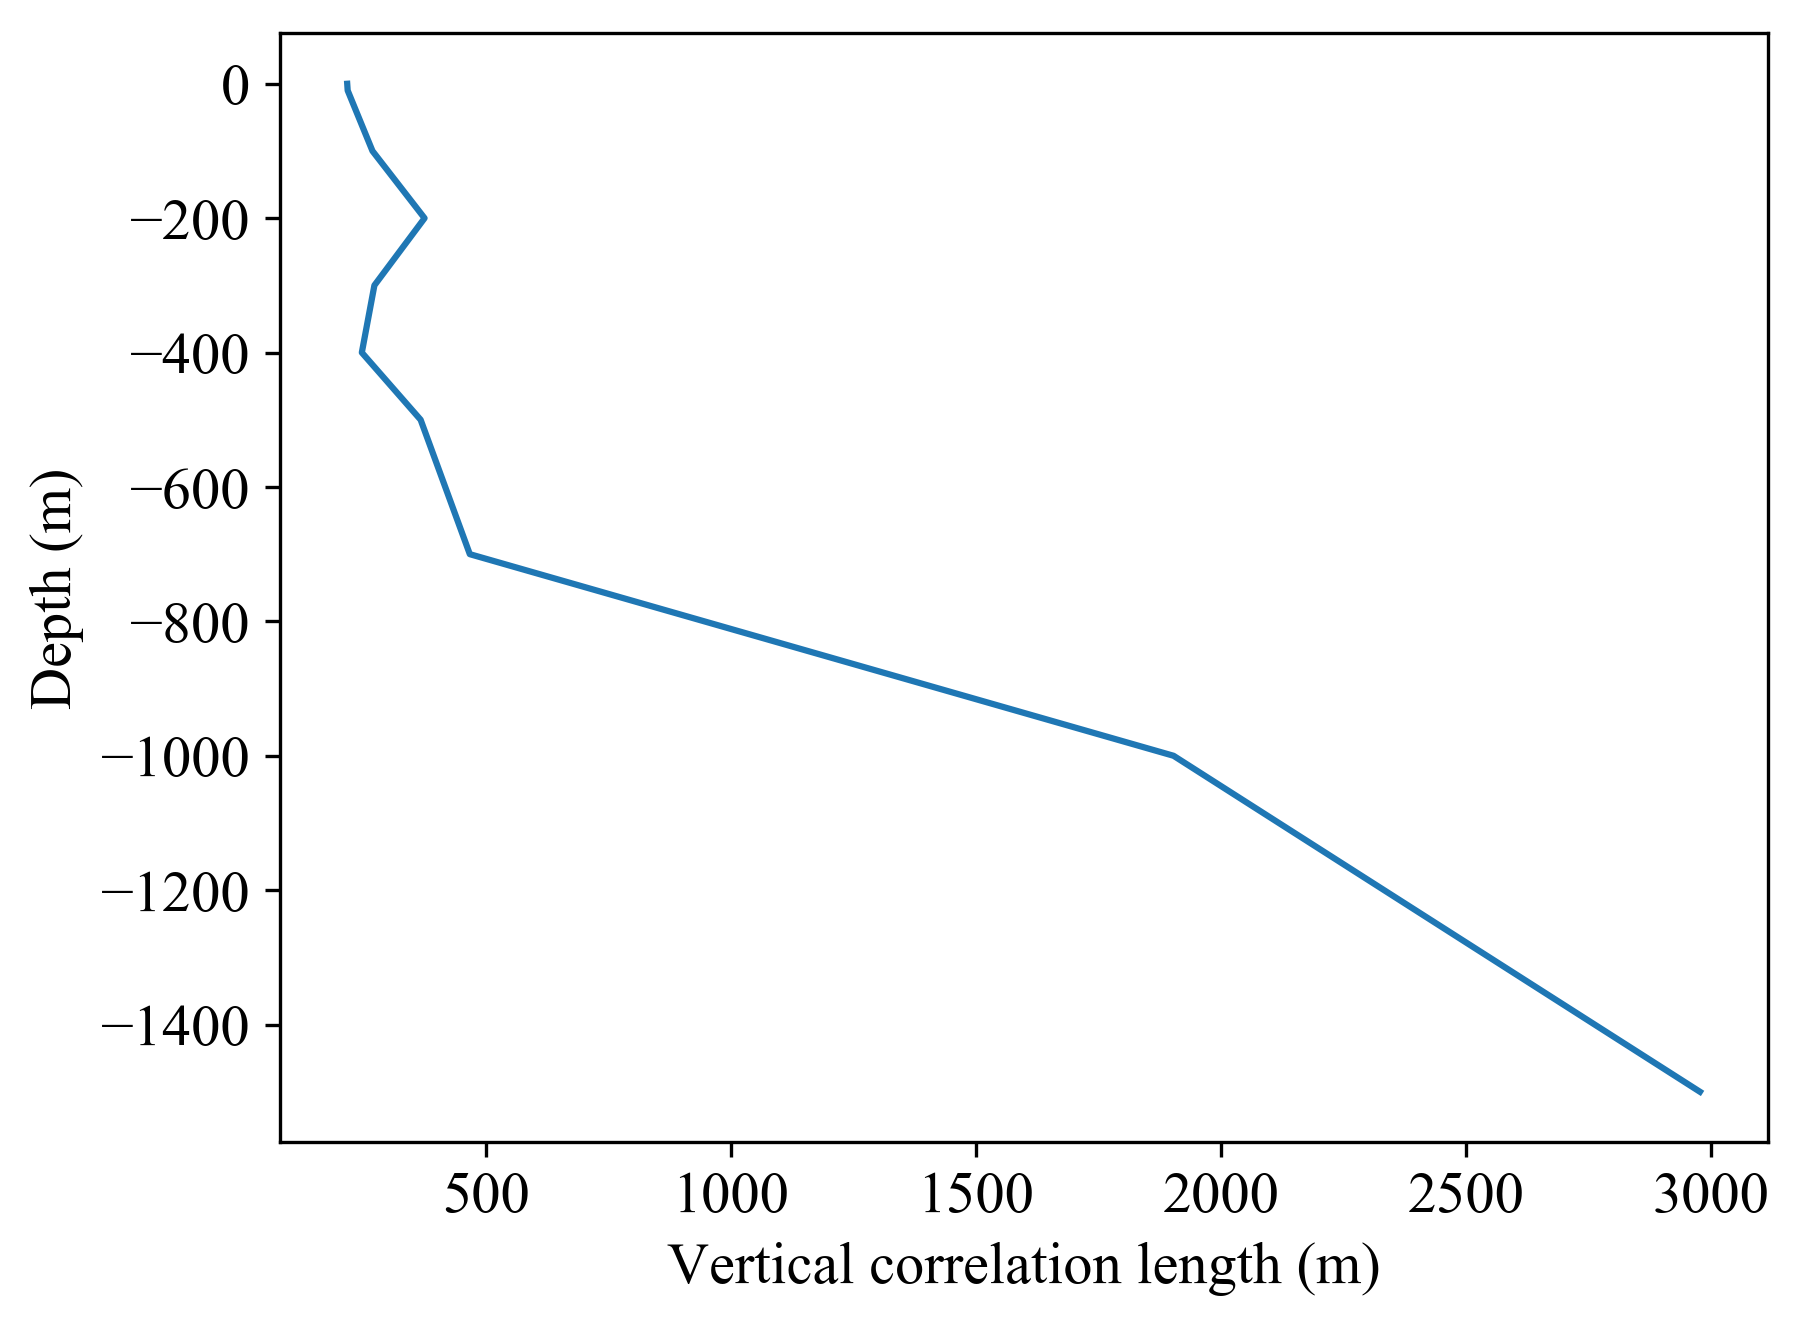

In [20]:
plot(lenz,-z)
xlabel("Vertical correlation length (m)")
ylabel("Depth (m)");